# Topic modeling using Gensim LDA
- TODO
  - exclude entitiy words (e.g: DATES)
  - exclude noisy words (e.g: suspect)
  - TFIDF (exclude very common words)

## Load LAPD newsgroups data
prepare the dataset we’ll be working with.
<br>(array of texts of news titles)


In [1]:
import os
import csv

data = []
dirname = '../../../out'
if os.path.exists(dirname):   
    for filename in os.listdir(dirname):
        filename = os.path.join(dirname, filename)
        with open(filename, 'r') as csv_file:
            reader = csv.reader(csv_file)
            next(reader, None)
            for row in reader:
                data.append(row[0])

# print first 5 titles
NUM_DOCUMENTS = len(data)
print('data:', NUM_DOCUMENTS, 'documens')
print('(top 5)')
print(' \n'.join(data[:5]))

data: 13956 documens
(top 5)
Two Suspects Arrested in Home Invasion Robbery    NR17032ma 
Suspect Arrested for Chinatown Murders    NR17033ml 
Hit and Run Collision Leaves Pedestrian Dead    NR17033ne 
Fatal Stabbing of a 27-year-old Man   NR17035im 
Press Conference   NA17014ma


## Preprocessing

### Remove emails and newline characters using regex

In [2]:
import re

def regex_clean(data):
    data_clean = data
    
    # Remove Emails
    data_clean = [re.sub('\S*@\S*\s?', 'EMAIL', sent) for sent in data_clean]

    # Remove new line characters
    data_clean = [re.sub('\s+', ' ', sent) for sent in data_clean]

    # Remove distracting single quotes
    data_clean = [re.sub("\'", "", sent) for sent in data_clean]
    
    return data_clean

data = regex_clean(data)
print('(top 5)')
print(' \n'.join(data[:5]))

(top 5)
Two Suspects Arrested in Home Invasion Robbery NR17032ma 
Suspect Arrested for Chinatown Murders NR17033ml 
Hit and Run Collision Leaves Pedestrian Dead NR17033ne 
Fatal Stabbing of a 27-year-old Man NR17035im 
Press Conference NA17014ma


### Tokenize, lowercase and clean-up text

In [3]:
# tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.
# Gensim’s simple_preprocess() is great for this. Additionally set deacc=True to remove the punctuations.

import gensim
from gensim.utils import simple_preprocess

def tokenize(data):
    return [simple_preprocess(text, deacc=True) for text in data]

data_words = tokenize(data)

# print first 5 processed titles
for tokens in data_words[:5]:
    print(tokens)

['two', 'suspects', 'arrested', 'in', 'home', 'invasion', 'robbery', 'nr', 'ma']
['suspect', 'arrested', 'for', 'chinatown', 'murders', 'nr', 'ml']
['hit', 'and', 'run', 'collision', 'leaves', 'pedestrian', 'dead', 'nr', 'ne']
['fatal', 'stabbing', 'of', 'year', 'old', 'man', 'nr', 'im']
['press', 'conference', 'na', 'ma']


### Create Bigram and Trigram Models

In [4]:
# Bigrams are two words frequently occurring together in the document. 
# Trigrams are 3 words frequently occurring.
# Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=3, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[4]]])

/home/yossi/dev/py/nlpy/env/lib/python3.5/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['press_conference', 'na', 'ma']


### Remove Stopwords, Make Bigrams and Lemmatize

In [5]:
# Define functions for stopwords, bigrams, trigrams and lemmatization

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'on'])

def remove_stopwords(data_words):
    return [[word for word in words if word not in stop_words] for words in data_words]

def make_bigrams(data_words):
    return [bigram_mod[words] for words in data_words]

def make_trigrams(data_words):
    return [trigram_mod[bigram_mod[words]] for words in data_words]

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def pos_allowed(word):
    return get_pos(word) in ['n', 'r', 'v', 'j']

def lemmatize(data_words):
    data_words_lemmatized = []
    for words in data_words:
        lemmatized = []
        for word in words:
#             pos = get_pos(word)
            lemmatized.append(word)
        data_words_lemmatized.append(lemmatized)
    return data_words_lemmatized

# call the functions above in order.
def preprocess(data_words):
                                      
    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Form Bigrams
    data_words_trigrams = make_trigrams(data_words_nostops)

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatize(data_words_trigrams)
    
    return data_lemmatized

data_lemmatized = preprocess(data_words)
print(data_lemmatized[:1])

[['two', 'suspects', 'arrested', 'home_invasion', 'robbery', 'nr']]


## Create the Dictionary and Corpus needed for Topic Modeling

In [6]:
# The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus.

from gensim import corpora

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
data_words = data_lemmatized

# Term Document Frequency
bow_corpus = [id2word.doc2bow(words) for words in data_words]

# View
# Gensim creates a unique id for each word in the document. 
# The produced corpus shown below is a mapping of (word_id, word_frequency).
# This is used as the input by the LDA model.
doc_id = 10
print(data_words[doc_id])
print(bow_corpus[doc_id])

# If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.
print()
print('id2word[0]:', id2word[0])

# Human readable format of corpus (term-frequency)
print()
print([[(id2word[id], freq) for id, freq in cp] for cp in bow_corpus[:5]])

['california', 'state', 'university', 'northridge', 'study', 'results', 'na', 'ml']
[(7, 1), (23, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1)]

id2word[0]: arrested

[[('arrested', 1), ('home_invasion', 1), ('nr', 1), ('robbery', 1), ('suspects', 1), ('two', 1)], [('arrested', 1), ('nr', 1), ('chinatown', 1), ('ml', 1), ('murders', 1), ('suspect', 1)], [('nr', 1), ('collision', 1), ('dead', 1), ('hit', 1), ('leaves', 1), ('ne', 1), ('pedestrian', 1), ('run', 1)], [('nr', 1), ('fatal', 1), ('im', 1), ('man', 1), ('old', 1), ('stabbing', 1), ('year', 1)], [('na', 1), ('press_conference', 1)]]


## Building the Topic Model

In [7]:
# We have everything required to train the LDA model. 
# In addition to the corpus and dictionary, you need to provide the number of topics as well.
# Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. 
# According to the Gensim docs, both defaults to 1.0/num_topics prior.
# chunksize is the number of documents to be used in each training chunk. 
# update_every determines how often the model parameters should be updated 
# passes is the total number of training passes.

# Build LDA model
NUM_TOPICS = 20
lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                           id2word=id2word,
                                           num_topics=NUM_TOPICS, 
                                           random_state=100,
                                           #update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           #alpha='auto',
                                           per_word_topics=True)

## View the topics in LDA model

In [8]:
# The above LDA model is built with N different topics where each topic is a combination of keywords 
# and each keyword contributes a certain weightage to the topic.

# We can see the keywords for each topic and the weightage(importance) of each keyword using 
# lda_model.print_topics()

# Print the Keyword in the topics
from pprint import pprint
pprint(lda_model.print_topics())
# lda_model.print_topics()
doc_lda = lda_model[bow_corpus]

[(0,
  '0.147*"murder" + 0.069*"suspect" + 0.069*"detectives" + 0.057*"nr" + '
  '0.050*"arrested" + 0.049*"arrest" + 0.034*"seek" + 0.022*"suspects" + '
  '0.020*"captured" + 0.019*"case"'),
 (1,
  '0.169*"officer" + 0.140*"shooting" + 0.100*"involved" + 0.036*"division" + '
  '0.034*"nrf" + 0.030*"area" + 0.024*"nr" + 0.022*"officers" + '
  '0.014*"suspect" + 0.014*"newton"'),
 (2,
  '0.033*"children" + 0.026*"theft" + 0.025*"nr" + 0.023*"publics_help" + '
  '0.019*"arrests" + 0.018*"two" + 0.017*"serial" + 0.017*"jr" + 0.016*"event" '
  '+ 0.016*"needed"'),
 (3,
  '0.117*"traffic" + 0.090*"collision" + 0.075*"fatal" + 0.068*"dies" + '
  '0.038*"nr" + 0.035*"south" + 0.025*"station" + 0.018*"custody" + '
  '0.016*"woman" + 0.016*"victim"'),
 (4,
  '0.086*"chief" + 0.065*"na" + 0.054*"lapd" + 0.037*"community" + '
  '0.026*"police" + 0.021*"school" + 0.019*"city" + 0.018*"bratton" + '
  '0.017*"charlie_beck" + 0.014*"la"'),
 (5,
  '0.098*"homicide" + 0.065*"investigation" + 0.056*"det

## Compute Model Perplexity and Coherence Score

In [9]:
# Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. 
# In my experience, topic coherence score, in particular, has been more helpful.

from gensim.models.coherencemodel import CoherenceModel

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
# https://rare-technologies.com/what-is-topic-coherence/
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.898759253464402

Coherence Score:  0.40491790517879284


## Visualize the topics-keywords

In [10]:
# Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. 
# There is no better tool than pyLDAvis package’s interactive chart.

# Visualize the topics
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, id2word)
vis

# Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.
# A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being 
# clustered in one quadrant.
# A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

/home/yossi/dev/py/nlpy/env/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
12     8.550251        1       1  0.165187 -0.156312
13     7.231360        1       2 -0.164073  0.019562
15     6.821567        1       3  0.169452 -0.062967
16     6.342556        1       4  0.136110 -0.114465
9      6.085882        1       5 -0.233711 -0.089469
7      5.898769        1       6  0.085649  0.272921
5      5.265902        1       7  0.051313  0.222185
1      5.123642        1       8 -0.005367  0.257549
6      4.938774        1       9  0.043498 -0.097752
3      4.808573        1      10  0.039205 -0.010909
4      4.735948        1      11 -0.208373 -0.051528
0      4.657382        1      12  0.153687 -0.044801
19     4.571177        1      13 -0.225998 -0.011284
10     4.402385        1      14 -0.165425 -0.042838
18     4.386738        1      15  0.116022 -0.076494
2      3.906168        1      16  0.078457  0.045065
11     3.490347        1      17  0.124366 -0.061451
14     3.246455        1      18 -0.077885 -0.065517
8      3.127074        1      19 -0.103574  0.011388
17     2.409048        1      20  0.021460  0.057119, topic_info=     Category         Freq           Term        Total  loglift  logprob
term                                                                    
3754  Default  1251.000000           year  1251.000000  30.0000  30.0000
1891  Default  1210.000000            old  1210.000000  29.0000  29.0000
4407  Default  1336.000000            man  1336.000000  28.0000  28.0000
4115  Default  1688.000000             na  1688.000000  27.0000  27.0000
2966  Default  1093.000000       shooting  1093.000000  26.0000  26.0000
521   Default  1082.000000        suspect  1082.000000  25.0000  25.0000
4960  Default   731.000000        officer   731.000000  24.0000  24.0000
5461  Default   700.000000           shot   700.000000  23.0000  23.0000
6320  Default   830.000000         police   830.000000  22.0000  22.0000
43    Default   829.000000        missing   829.000000  21.0000  21.0000
477   Default   742.000000         murder   742.000000  20.0000  20.0000
1121  Default  1768.000000           lapd  1768.000000  19.0000  19.0000
6331  Default   560.000000        traffic   560.000000  18.0000  18.0000
4855  Default   480.000000            hit   480.000000  17.0000  17.0000
5928  Default   476.000000            run   476.000000  16.0000  16.0000
797   Default   545.000000            los   545.000000  15.0000  15.0000
3360  Default  3530.000000             nr  3530.000000  14.0000  14.0000
414   Default   536.000000        angeles   536.000000  13.0000  13.0000
5339  Default   437.000000       homicide   437.000000  12.0000  12.0000
6077  Default   433.000000       involved   433.000000  11.0000  11.0000
3998  Default   664.000000         killed   664.000000  10.0000  10.0000
5711  Default   523.000000     detectives   523.000000   9.0000   9.0000
411   Default   451.000000        robbery   451.000000   8.0000   8.0000
2052  Default   367.000000      collision   367.000000   7.0000   7.0000
5894  Default   383.000000            one   383.000000   6.0000   6.0000
582   Default   385.000000            dui   385.000000   5.0000   5.0000
5428  Default   345.000000          chief   345.000000   4.0000   4.0000
6149  Default   321.000000         reward   321.000000   3.0000   3.0000
240   Default   521.000000       officers   521.000000   2.0000   2.0000
5259  Default   349.000000           gang   349.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
6318  Topic20    36.690414     operations    37.562401   3.7025  -4.0170
3616  Topic20    33.060299  boyle_heights    33.933292   3.6999  -4.1212
2113  Topic20    29.248327    celebration    30.120312   3.6966  -4.2437
725   Topic20    24.439312      passenger    25.311300   3.6909  -4.4233
67    Topic20    22.895220           club    23.767206   3.6886  -4.4886
6500  Topic20    

## Building LDA Mallet Model

In [13]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
from gensim.models.wrappers import LdaMallet
mallet_path = '~/dev/py/nlpy/3rd-party/mallet-2.0.8/bin/mallet' # update this path
ldamallet = LdaMallet(mallet_path, corpus=bow_corpus, num_topics=NUM_TOPICS, id2word=id2word)

In [14]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(2,
  [('na', 0.07725430597771023),
   ('safety', 0.04331306990881459),
   ('operation', 0.03368794326241135),
   ('news_conference', 0.03115501519756839),
   ('program', 0.03115501519756839),
   ('enforcement', 0.030395136778115502),
   ('school', 0.02684903748733536),
   ('holiday', 0.025835866261398176),
   ('children', 0.023809523809523808),
   ('memorial', 0.02127659574468085)]),
 (18,
  [('nr', 0.1041017653167186),
   ('man', 0.09553478712357218),
   ('found', 0.08566978193146417),
   ('car', 0.05425752855659398),
   ('dead', 0.05399792315680166),
   ('rh', 0.052440290758047764),
   ('vehicle', 0.04932502596053998),
   ('pv', 0.03608515057113188),
   ('victim', 0.03556593977154725),
   ('home', 0.02570093457943925)]),
 (8,
  [('murder', 0.20632603406326033),
   ('suspect', 0.08856447688564477),
   ('reward', 0.08248175182481751),
   ('offered', 0.058394160583941604),
   ('publics_help', 0.032846715328467155),
   ('attempt', 0.03236009732360097),
   ('case', 0.02165450121654501),

## How to find the optimal number of topics for LDA?

In [11]:
# An approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) 
# and pick the one that gives the highest coherence value.
# Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. 
# Picking an even higher value can sometimes provide more granular sub-topics.
# If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [19]:
# Can take a long time to run.
start=60; limit=80; step=5;
model_list, coherence_values = compute_coherence_values(
    dictionary=id2word, 
    corpus=bow_corpus, 
    texts=data_lemmatized, 
    start=start, 
    limit=limit, 
    step=step)

ValueError: x and y must have same first dimension, but have shapes (11,) and (4,)

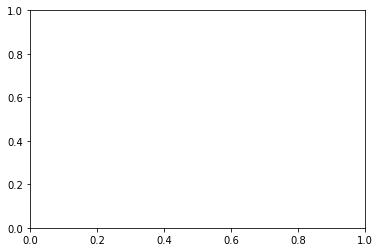

In [21]:
# Show graph
from matplotlib import pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


# TODO: OLD

## Running LDA/LSI using Bag of Words

In [ ]:
# Create Gensim LDA and LSI models using BOW corpus.

from gensim import models, corpora

NUM_TOPICS = 30

# Build a Dictionary - association word to numeric id
dictionary = corpora.Dictionary(data_words)

# Gensim filter_extremes
# dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# Transform the collection of texts to a numerical form
bow_corpus = [dictionary.doc2bow(text) for text in data_words]
 
# Have a look at how the 10th document looks like: [(word_id, count), ...]
# e.g: [(12, 3), (14, 1), (21, 1), (25, 5), (30, 2), (31, 5), (33, 1), (42, 1), (43, 2),  ...
doc_id = 10
print(data_words[doc_id])
print(bow_corpus[doc_id])

# Build the LDA model (Latent Dirichlet Allocation)
lda_model_bow = gensim.models.LdaMulticore(corpus=bow_corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=2, workers=4)

# Build the LSI model (Latent Semantic Analysis or Latent Semantic Indexing)
lsi_model_bow = models.LsiModel(corpus=bow_corpus, num_topics=NUM_TOPICS, id2word=dictionary)

In [ ]:
# For each topic, print the first 5 most representative topics.

print("LDA Model (bow):")
print("=" * 20)
for idx in range(NUM_TOPICS):
    # Print the first 5 most representative topics
    print("Topic %s:" % idx, lda_model_bow.print_topic(idx, 5)) 

print()

print("LSI Model (bow):")
print("=" * 20)
for idx in range(NUM_TOPICS):
    # Print the first 5 most representative topics
    print("Topic %s:" % idx, lsi_model_bow.print_topic(idx, 5))


In [ ]:
# Let’s now put the models to work and transform unseen documents to their topic distribution:

texts = [
    "A men found killed in the park.", 
    "A woman was raped in the park."
]

for text in texts:
    print()
    print(text)
    
    bow = dictionary.doc2bow(preprocess(text))

    # print(lda_model[bow])
    # [(0, 0.020005183), (1, 0.020005869), (2, 0.02000626), (3, 0.020005472), (4, 0.020009108), (5, 0.020005926), (6, 0.81994385), (7, 0.020006068), (8, 0.020006327), (9, 0.020005994)]
    # print(max(lda_model[bow], key=lambda item:item[1]))
    print('lda:', sorted(lda_model_bow[bow], key=lambda item:item[1], reverse=True)[:3])

    # print(lsi_model[bow])
    # [(0, 0.091615426138426506), (1, -0.0085557463300508351), (2, 0.016744863677828108), (3, 0.040508186718598529), (4, 0.014201267714185898), (5, -0.012208538275305329), (6, 0.031254053085582149), (7, 0.017529584659403553), (8, 0.056957633371540077), (9, 0.025989149894888153)]
    print('lsi:', sorted(lsi_model_bow[bow], key=lambda item:item[1], reverse=True)[:3])

## Running LDA/LSI using TF-IDF

In [ ]:
tfidf = models.TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

# Build the LDA model (Latent Dirichlet Allocation)
lda_model_tfidf = gensim.models.LdaMulticore(corpus=tfidf_corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=2, workers=4)

# Build the LSI model (Latent Semantic Analysis or Latent Semantic Indexing)
lsi_model_tfidf = models.LsiModel(corpus=tfidf_corpus, num_topics=NUM_TOPICS, id2word=dictionary)

In [ ]:
# For each topic, print the first 5 most representative topics.

print("LDA Model (tfidf):")
print("=" * 20)
for idx in range(NUM_TOPICS):
    # Print the first 5 most representative topics
    print("Topic %s:" % idx, lda_model_tfidf.print_topic(idx, 5)) 

print()

print("LSI Model (tfidf):")
print("=" * 20)
for idx in range(NUM_TOPICS):
    # Print the first 5 most representative topics
    print("Topic %s:" % idx, lsi_model_tfidf.print_topic(idx, 5))


## Using Scikit-Learn for Topic Modeling

In [ ]:
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer

import nltk.stem
stemmer = nltk.stem.SnowballStemmer('english')

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

# vectorizer = StemmedCountVectorizer(
#     analyzer="word", 
#     min_df=5, max_df=0.9, 
#     stop_words='english', lowercase=True, 
#     token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')

vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                ngram_range = (1,2), 
                                min_df = 20,
                                max_df = 1.0)

data_vectorized = vectorizer.fit_transform(data)

# vectorizer = CountVectorizer(
#     min_df=5, max_df=0.9, 
#     stop_words='english', lowercase=True, 
#     token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
# data_vectorized = vectorizer.fit_transform(data)

# Build a Latent Dirichlet Allocation Model
lda_model = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online')
lda_Z = lda_model.fit_transform(data_vectorized)
print(lda_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)
 
# Build a Non-Negative Matrix Factorization Model
nmf_model = NMF(n_components=NUM_TOPICS)
nmf_Z = nmf_model.fit_transform(data_vectorized)
print(nmf_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)
 
# Build a Latent Semantic Indexing Model
lsi_model = TruncatedSVD(n_components=NUM_TOPICS)
lsi_Z = lsi_model.fit_transform(data_vectorized)
print(lsi_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)
 
 
# Let's see how the first document in the corpus looks like in different topic spaces
print(lda_Z[0])
print(nmf_Z[0])
print(lsi_Z[0])

In [ ]:
def print_topics(model, vectorizer, top_n=6):
    for idx, topic in enumerate(model.components_):
        print()
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])

print("LDA Model:")
print("=" * 20)
print_topics(lda_model, vectorizer)
 
print()
print("NMF Model:")
print("=" * 20)
print_topics(nmf_model, vectorizer)

print()
print("LSI Model:")
print("=" * 20)
print_topics(lsi_model, vectorizer)

In [ ]:
# Transforming an unseen document
texts = [
    "A men found killed in the park.", 
    "A woman was raped in the park."
]

for text in texts:
    print()
    print(text)
    x = nmf_model.transform(vectorizer.transform([text]))[0]
    print(x)

## Plotting words and documents in 2D with SVD

In [ ]:
import pandas as pd
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet
output_notebook()

In [ ]:
# plot documents in 2D
svd = TruncatedSVD(n_components=2)
documents_2d = svd.fit_transform(data_vectorized)
 
df = pd.DataFrame(columns=['x', 'y', 'document'])
df['x'], df['y'], df['document'] = documents_2d[:,0], documents_2d[:,1], range(len(data))
 
source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="document", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=600, plot_height=600)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
# plot.add_layout(labels)
show(plot, notebook_handle=True)

In [ ]:
# display words in 2D we just need to transpose the vectorized data: 
# words_2d = svd.fit_transform(data_vectorized.T).

svd = TruncatedSVD(n_components=2)
words_2d = svd.fit_transform(data_vectorized.T)
 
df = pd.DataFrame(columns=['x', 'y', 'word'])
df['x'], df['y'], df['word'] = words_2d[:,0], words_2d[:,1], vectorizer.get_feature_names()
 
source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="word", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=600, plot_height=600)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True)

In [ ]:
# lda

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
 
NUM_TOPICS = 40

stem = False

if stem:
    vectorizer = StemmedCountVectorizer(
        analyzer="word", 
        min_df=5, max_df=0.9, 
        stop_words='english', lowercase=True, 
        token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
else:
#     vectorizer = TfidfVectorizer(
#         min_df=5, max_df=0.9, 
#         stop_words='english', lowercase=True, 
#         token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')

#     vectorizer = CountVectorizer(strip_accents = 'unicode',
    vectorizer = TfidfVectorizer(strip_accents = 'unicode',
                                    stop_words = 'english',
                                    lowercase = True,
                                    token_pattern = r'\b[a-zA-Z]{3,}\b',
                                    ngram_range = (1,2), 
                                    min_df = 20,
                                    max_df = 1.0)

data_vectorized = vectorizer.fit_transform(data)
 
# Build a Latent Dirichlet Allocation Model
lda_model = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online')
lda_Z = lda_model.fit_transform(data_vectorized)

# Transforming an unseen document
texts = [
    "A men found killed in the park.", 
    "A woman was raped in the park."
]

for text in texts:
    print()
    print(text)
    x = lda_model.transform(vectorizer.transform([text]))[0]
    print(x, x.sum())

In [ ]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
panel